In [2]:
from pathlib import Path
from typing import Tuple, List
from collections import defaultdict
from random import sample
import logging
import pickle

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import seaborn as sns

# Data description

## Metadata
1 ligne par fichier, des fois 2 ; dans le cas où il y a 2 lignes prendre la ligne où le CPA est le plus élevé (correspond à une seconde analyse où plus de séquences d'ADN ont été analysées)

3 colonnes CPA ont été normalisées par la fonction racine carré (afin de limiter au maximum l'impact des outlayers lors des analyses). Les valeurs CPA que l'on voit sont en fait les racines-carrés des valeurs initiales (un petit carré sur les colonnes permettra de retomber sur les valeurs initiales, non normalisées) 

* CPA : % d'altération. Nb d'altération détectée par rapport à une baseline. Estimation de la quantité d'adn de la tumeur qui se trouve dans le sang. C'est une valeur pas un pourcentage.
* nb.reads = dans un premier temps on s'en fiche (valeur qui permet de normaliser) Nombre de séquences scanées. Si très bas on fait moins confiance.
* sexe
* age
* htum : grosseur de la tumeur au diagnostic (ie. le jour où on fait la radio)
* relapse : 1 rechute, 0 pas rechute
* etat2 : statut du patient (0 vivant, 1 décédé)
* id.x : id patient
* time_point : 3 valeurs possibles (DIAG, AVANT_CHIR, FIN_TTT)
* time_OS : durée de suivi total
* time_PFS : nombre de jour entre la rechute et le diagnostique
* rep_histo : reponse histologique. Bon ou mauvais répondeur. On l'a après le 1er traitement
* puberte : + parlant que l'âge
* meta_bis : présence de métastase au diagnostique


## Data

En fonction des patients on n'a pas tous les time points
* Diagnotic
* Avant chirurgie (déjà un traitement)
* Fin T : fin traitnement

Chaque chromosome est découpé en fenêtres => même fenetres pour tous les patients
Indicateur de présence d'ADN tumoral (0 : 2 copies, > 0 copie en trop, < 0 perte)

# Preprocess data

## Load files

In [3]:
OUTPUT_DIR = Path('..') / 'data' / 'intermediate'

data_dir = Path('..') / 'data' / 'raw' / 'results'
metadata_path = Path('..') / 'data' / 'raw' / 'metadata_DMLHT_ctDNA.csv'
#metadata_path_old = Path('..') / 'data' / 'raw' / 'metadata_OS2006_ctdna.csv'

In [4]:
metadata = pd.read_csv(metadata_path, sep='\t', skiprows=1)

In [5]:
# get columns description
col_desc = !head -n 1 ../data/raw/metadata_DMLHT_ctDNA.csv
col_desc = pd.concat([pd.Series(metadata.columns), pd.Series(col_desc[0].split('\t'))], axis=1)
col_desc.columns = ['col_name', 'desc']
col_desc

,col_name,desc
0,sex,Genre du patient
1,age,Age du patient (années)
2,pub,Stade pubertaire
3,htum,hauteur de la tumeur (mm)
4,meta_bis,Présence (ou non) de metastase au diagnostic
5,chimgr,Type de chimio
6,rep_histo,réponse histologique : bonne (GR) ou mauvaise ...
7,relapse,"Rechute (1=oui, 0= non)"
8,etat2,Statut vital (1 =décédé)
9,time_OS,Survie globale jusqu’à la dernière date de sui...


In [6]:
def get_infos_from_filename(filename: str) -> Tuple[str, str]:
    filename = filename.split('.')[0]
    splitted_filename = filename.split('_')
    id_patient = f'{splitted_filename[0]}_{splitted_filename[1]}'
    time_point = f'{splitted_filename[2]}_{splitted_filename[3]}' if len(splitted_filename) == 4 else splitted_filename[2]
    return id_patient, time_point


def load_all_data_patient(data_dir: Path) -> defaultdict:
    data_patient = defaultdict(dict)

    for p in data_dir.iterdir():
        if not p.is_file():
            continue
        filename = str(p).split('/')[-1]
        try:
            id_patient, time_point = get_infos_from_filename(filename)
        except IndexError as e:
            print(f'Error reading file : {filename}, {e}')
            continue
        data_patient[id_patient][time_point] = pd.read_csv(p, sep='\t')
    
    return data_patient

In [7]:
data_patient = load_all_data_patient(data_dir)
print(f'There are {len(data_patient)} patient')

Error reading file : .placeholder, list index out of range
There are 182 patient


## Organize data

In [8]:
patient_all_time_points = {patient_id: data for patient_id, data in data_patient.items() if len(data) == 3}
print(f'There are {len(patient_all_time_points)} patient with data for the 3 time points')

There are 115 patient with data for the 3 time points


In [9]:
patient_diag_time_point = {patient_id: {'DIAG': data['DIAG']} for patient_id, data in data_patient.items() if data.get('DIAG') is not None}
print(f'There are {len(patient_diag_time_point)} patient with data for DIAG time point')

There are 177 patient with data for DIAG time point


In [10]:
patient_chir_time_point = {patient_id: {'AVANT_CHIR': data['AVANT_CHIR']} for patient_id, data in data_patient.items() if data.get('AVANT_CHIR') is not None}
print(f'There are {len(patient_chir_time_point)} patient with data for AVANT_CHIR time point')

There are 143 patient with data for AVANT_CHIR time point


In [11]:
patient_end_time_point = {patient_id: {'FIN_TT': data['FIN_TT']} for patient_id, data in data_patient.items() if data.get('FIN_TT') is not None}
print(f'There are {len(patient_end_time_point)} patient with data for FIN_TT time point')

There are 143 patient with data for FIN_TT time point


In [12]:
## Check that there are no errors
nb_files = 0
for data in data_patient.values():
    nb_files += len(data.values())
assert nb_files == len(patient_diag_time_point) \
    + len(patient_chir_time_point) \
    + len(patient_end_time_point)

## Transform data
### Transpose data

In [13]:
def transpose_data_one_patient(data: pd.DataFrame) -> pd.DataFrame:
    one_data = data.copy()
    one_data = one_data[['id', 'ratio', 'zscore']].set_index('id').stack().reset_index()
    one_data.columns = ['id', 'score_label', 'value']
    one_data['col_name'] = one_data['id'] + '_' + one_data['score_label']
    return one_data.set_index('col_name')['value'].to_frame().T


def format_all_data_as_df(patient_data: defaultdict) -> pd.DataFrame:
    transpose_data = []
    ids_patient = []
    
    for patient_id, data in patient_data.items():
        for time_point, data in data.items():
            transpose_data.append(transpose_data_one_patient(data))
            ids_patient.append((patient_id, time_point))
        
    transpose_data_df = pd.concat(transpose_data, axis=0).reset_index(drop=True)
    ids_patient_df = pd.DataFrame(ids_patient, columns=['patient_id', 'time_point'])
    
    return pd.concat([ids_patient_df, transpose_data_df], axis=1)


def pivot_data(patient_all_time_points_df: pd.DataFrame) -> pd.DataFrame:
    """create 1 column per time_point x gene col"""
    pivoted = patient_all_time_points_df.pivot(index=['patient_id'], columns=['time_point'])
    pivoted.columns = ['_'.join(col).strip() for col in pivoted.columns.values]
    pivoted = pivoted.reset_index()
    return pivoted

In [14]:
patient_diag_time_point_df = format_all_data_as_df(patient_diag_time_point)
patient_chir_time_point_df = format_all_data_as_df(patient_chir_time_point)
patient_end_time_point_df = format_all_data_as_df(patient_end_time_point)

In [15]:
patient_all_time_points_df = format_all_data_as_df(patient_all_time_points)

In [16]:
patient_all_time_points_pivoted = pivot_data(patient_all_time_points_df)

In [17]:
patient_diag_time_point_df.head()

,patient_id,time_point,1:1000001-2000000_ratio,1:1000001-2000000_zscore,1:3000001-4000000_ratio,1:3000001-4000000_zscore,1:4000001-5000000_ratio,1:4000001-5000000_zscore,1:5000001-6000000_ratio,1:5000001-6000000_zscore,...,Y:20000001-21000000_ratio,Y:20000001-21000000_zscore,Y:21000001-22000000_ratio,Y:21000001-22000000_zscore,Y:56000001-57000000_ratio,Y:56000001-57000000_zscore,2:225000001-226000000_ratio,2:225000001-226000000_zscore,8:76000001-77000000_ratio,8:76000001-77000000_zscore
0,OS2006_273,DIAG,-0.041425,-0.976791,-0.062404,-1.544387,-0.003995,-0.110273,-0.067551,-1.800513,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OS2006_20,DIAG,-0.069139,-0.879803,-0.065056,-0.964620,-0.076228,-1.209564,0.059106,0.861878,...,-0.075287,-0.983087,-0.061387,-0.743372,0.030197,0.363847,NaN,NaN,NaN,NaN
2,OS2006_37,DIAG,0.096445,1.610565,0.167901,2.627620,0.165071,2.363639,0.143986,2.085317,...,0.068260,0.667947,0.142330,1.608445,-0.451219,-5.174899,NaN,NaN,NaN,NaN
3,OS2006_320,DIAG,0.059786,1.019763,0.117976,2.038471,0.133299,2.370724,0.190704,3.304253,...,-0.368986,-3.677375,-0.312518,-3.143064,-0.033962,-0.449842,NaN,NaN,NaN,NaN
4,OS2006_504,DIAG,-0.114674,-1.678215,-0.100271,-1.710686,-0.092227,-1.720962,-0.039484,-0.659434,...,-0.216662,-2.878748,-0.087349,-1.327402,-0.082043,-1.076253,-0.154327,-2.448759,NaN,NaN


## Clean metadata

In [18]:
metadata_df = metadata.copy()
metadata_df = metadata_df.rename(columns={'Code': 'patient_id'})
metadata_df = metadata_df.sort_values('cpa_diagnostic', ascending=False).drop_duplicates(['patient_id'], keep='first')

In [19]:
metadata_df.head()

,sex,age,pub,htum,meta_bis,chimgr,rep_histo,relapse,etat2,time_OS,time_PFS,cpa_finTT,cpa_diagnostic,cpa_chirurgie,EFS,patient_id
33,Feminin,20.55,0.0,11.6,1,MTX,GR,0,0,2628.0,NaN,0.378365,1.620802,NaN,2628.0,OS2006_34
93,Feminin,12.91,1.0,9.3,0,MTX,GR,1,0,1786.0,1412.0,0.407198,1.255325,0.375167,1412.0,OS2006_424
10,Masculin,4.71,1.0,10.2,0,MTX,NaN,1,1,261.0,59.0,NaN,1.180568,NaN,59.0,OS2006_6
157,Feminin,15.62,0.0,15.0,1,MTX,NaN,1,0,1100.0,63.0,0.424170,1.172536,0.405512,63.0,OS2006_543
70,Feminin,12.56,0.0,11.4,1,MTX,NaN,1,1,258.0,61.0,NaN,1.160646,0.441871,61.0,OS2006_357


# join data and metadata

## one row per patient, all time points

In [20]:
merged = pd.merge(metadata_df, patient_all_time_points_pivoted, on='patient_id', how='outer') 

In [21]:
print(f"proportion of nulls: {merged['1:6000001-7000000_ratio_DIAG'].isna().sum()/len(merged)}")

proportion of nulls: 0.36813186813186816


In [22]:
assert len(merged.patient_id.unique()) == len(merged), "there are duplicated values"

## per time point

In [23]:
def merge_data_and_metadata(
        metadata_df: pd.DataFrame,
        data: pd.DataFrame,
        to_drop: List[str],
        time_points: List[str],
        ) -> pd.DataFrame:
    data_processed = data.copy()
    data_processed = data_processed.drop(columns=to_drop, errors="ignore")
    data_processed = data_processed[data_processed['time_point'].isin(time_points)]
    data_processed = pivot_data(data_processed)
    return pd.merge(
        metadata_df.drop(columns=to_drop, errors="ignore"),
        data_processed,
        how='inner',
        on='patient_id',
    )

In [24]:
TO_DROP = ['cpa_chirurgie', 'cpa_finTT', 'rep_histo']    # to avoid data leakage
TIME_POINTS = ['DIAG']    # we assure 'AVANT_CHIR' is actually after diag

merged_diag = merge_data_and_metadata(
    metadata_df,
    patient_all_time_points_df,
    to_drop=TO_DROP,
    time_points=TIME_POINTS)

In [25]:
TO_DROP = ['cpa_finTT']    # to avoid data leakage
TIME_POINTS = ['DIAG', 'AVANT_CHIR']    # we assume 'avant_chir' is after chir

merged_chir = merge_data_and_metadata(
    metadata_df,
    patient_all_time_points_df,
    to_drop=TO_DROP,
    time_points=TIME_POINTS)

In [26]:
# merged
merged.to_csv(OUTPUT_DIR / 'data_metadata.csv', index=False)    # all time points
merged_diag.to_csv(OUTPUT_DIR / 'data_metadata_diag.csv', index=False)    # diag data only
merged_chir.to_csv(OUTPUT_DIR / 'data_metadata_chir.csv', index=False)    # diag + chir data

# data
patient_all_time_points_pivoted.to_csv(OUTPUT_DIR / 'data_all_time_point_pivoted.csv', index=False)    # one row per patient
patient_all_time_points_df.to_csv(OUTPUT_DIR / 'data_data_all_time_point.csv', index=False)    # one row per patient per time point

# metadata
metadata_df.to_csv(OUTPUT_DIR / "metadata.csv", index=False)

# Load processed data

In [27]:
OUTPUT_DIR = Path('..') / 'data' / 'intermediate'

# merged
merged = pd.read_csv(OUTPUT_DIR / 'data_metadata.csv')    # all time points
merged_diag = pd.read_csv(OUTPUT_DIR / 'data_metadata_diag.csv')    # diag data only
merged_chir = pd.read_csv(OUTPUT_DIR / 'data_metadata_chir.csv')    # diag + chir data

# data
patient_all_time_points_pivoted = pd.read_csv(OUTPUT_DIR / 'data_all_time_point_pivoted.csv')    # one row per patient
patient_all_time_points_df = pd.read_csv(OUTPUT_DIR / 'data_data_all_time_point.csv')    # one row per patient per time point

# metadata
metadata_df = pd.read_csv(OUTPUT_DIR / "metadata.csv")

# Outliers
## Because CPA to important

In [28]:
# come frome the previous notebook
outliers_ids = ['OS2006_34', 'OS2006_548', 'OS2006_20']

## Because time_os too low

<AxesSubplot:>

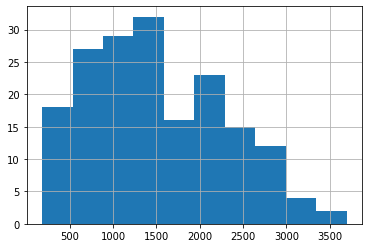

In [29]:
metadata_df['time_OS'].hist()

In [30]:
metadata_df[metadata_df['time_OS'] > 700].shape

(150, 16)

In [31]:
metadata_df.shape

(182, 16)

In [32]:
outliers_ids.extend(metadata_df.loc[(metadata_df['time_OS'] < 700) & (metadata_df['relapse'] == 0), 'patient_id'].tolist())

## Remove outliers

In [33]:
len(outliers_ids)

31

In [34]:
patient_diag_time_point_no_outlier_df = patient_diag_time_point_df[~patient_diag_time_point_df['patient_id'].isin(outliers_ids)]
patient_diag_time_point_no_outlier_df.reset_index(drop=True, inplace=True)

# build features / labels

In [35]:
patient_diag_time_point_no_outlier_df

,patient_id,time_point,1:1000001-2000000_ratio,1:1000001-2000000_zscore,1:3000001-4000000_ratio,1:3000001-4000000_zscore,1:4000001-5000000_ratio,1:4000001-5000000_zscore,1:5000001-6000000_ratio,1:5000001-6000000_zscore,...,Y:20000001-21000000_ratio,Y:20000001-21000000_zscore,Y:21000001-22000000_ratio,Y:21000001-22000000_zscore,Y:56000001-57000000_ratio,Y:56000001-57000000_zscore,2:225000001-226000000_ratio,2:225000001-226000000_zscore,8:76000001-77000000_ratio,8:76000001-77000000_zscore
0,OS2006_273,DIAG,-0.041425,-0.976791,-0.062404,-1.544387,-0.003995,-0.110273,-0.067551,-1.800513,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OS2006_37,DIAG,0.096445,1.610565,0.167901,2.627620,0.165071,2.363639,0.143986,2.085317,...,0.068260,0.667947,0.142330,1.608445,-0.451219,-5.174899,NaN,NaN,NaN,NaN
2,OS2006_320,DIAG,0.059786,1.019763,0.117976,2.038471,0.133299,2.370724,0.190704,3.304253,...,-0.368986,-3.677375,-0.312518,-3.143064,-0.033962,-0.449842,NaN,NaN,NaN,NaN
3,OS2006_454,DIAG,-0.080659,-2.219705,-0.087107,-2.564875,0.091030,2.927293,0.071785,2.375454,...,-0.239354,-6.671689,0.008678,0.287086,-0.068674,-1.861192,NaN,NaN,-0.032918,-0.994376
4,OS2006_356,DIAG,0.191670,4.122737,0.153430,2.938652,0.042777,0.815245,0.005525,0.132439,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,OS2006_29,DIAG,0.131603,3.533083,0.130085,3.242053,0.007131,0.148884,0.002434,0.030667,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.019207,-0.540331,0.025165,0.639913
143,OS2006_74,DIAG,-0.012060,-0.267332,0.048694,1.356621,0.051124,1.365275,0.059460,1.660112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.023205,0.512286
144,OS2006_291,DIAG,-0.011405,-0.350386,0.003667,0.119972,0.014676,0.380061,0.048636,1.383245,...,0.160422,3.827754,-0.032544,-0.917820,0.104093,2.307465,NaN,NaN,NaN,NaN
145,OS2006_196,DIAG,0.003971,-0.009709,0.024788,0.188285,-0.071519,-0.754290,-0.027218,-0.288237,...,-0.673586,-5.267646,-0.448902,-3.714471,-0.171304,-1.512941,NaN,NaN,NaN,NaN


In [36]:
def remove_x_and_y_chrom(features: pd.DataFrame) -> pd.DataFrame:
    return features[[x for x in features.columns if not (x.startswith('X:') or x.startswith('Y:'))]]

def compute_features(data: pd.DataFrame, score: str = 'ratio') -> pd.DataFrame:
    features = data[[x for x in data.columns if f'_{score}' in x]]
    features = remove_x_and_y_chrom(features)
    features.fillna(0, inplace=True)
    return features

In [37]:
X = compute_features(patient_diag_time_point_no_outlier_df)

In [38]:
y_df = pd.merge(patient_diag_time_point_no_outlier_df, metadata_df[['patient_id', 'relapse']], on='patient_id', how='left')['relapse']

In [39]:
y_df.value_counts()

0    94
1    53
Name: relapse, dtype: int64

In [40]:
np.unique(y_df)

array([0, 1])

In [41]:
y = y_df.to_list()

# Training
## basic cross validation

In [42]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression


In [43]:
lr = LogisticRegression(class_weight='balanced')

In [44]:
cv_score = cross_val_score(lr, X, y, cv=5)

In [45]:
mean_score = 100 * np.mean(cv_score)
std_score = 100 * np.std(cv_score)

In [46]:
std_score

4.539866128306095

In [47]:
mean_score

66.66666666666667

In [48]:
cv_score

array([0.66666667, 0.66666667, 0.68965517, 0.72413793, 0.5862069 ])

In [49]:
np.std(cv_score)

0.04539866128306094

## Take random features
### use all possible combinaitions

In [50]:
features_name = X.columns.tolist()

In [51]:
len(features_name)

2498

In [52]:
from math import factorial
nb_features_to_pick = 10
nb_combinaison = factorial(2498)/(factorial(nb_features_to_pick) * factorial(2498 - nb_features_to_pick))
nb_combinaison

2.5605178712370793e+27

## Take random features

In [53]:
logging.basicConfig(filename='adn_circulant_brute_force.log',
                    filemode='a',
                    format='%(message)s',
                    level=logging.INFO)

In [65]:
pickle.dump(X, open(Path('..') / 'features' / 'X.pkl', 'wb'))
pickle.dump(y, open(Path('..') / 'features' /'y.pkl', 'wb'))

In [59]:
features_name = X.columns.tolist()
nb_features_to_pick = 200

def compute_model_with_random_features(i):
    features_to_use = sample(features_name, nb_features_to_pick)
    lr = LogisticRegression()
    cv_score = cross_val_score(lr, X[features_to_use], y, cv=5)
    mean_score = round(100 * np.mean(cv_score), 1)
    std_score = round(100 * np.std(cv_score), 1) 
    logging.warning(f'{mean_score}|{std_score}|{cv_score}')

    
    score_to_save = {
        'features': features_to_use,
        'mean_score': round(100 * np.mean(cv_score), 1),
        'std_score': round(100 * np.std(cv_score), 1) 
    }
    #print(score_to_save)

In [61]:
from multiprocessing import Pool
from tqdm import tqdm
with Pool() as p:
    list(tqdm(p.imap(compute_model_with_random_features, range(100), chunksize=10), total=100))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.42it/s]


In [55]:
toto

NameError: name 'toto' is not defined

ERROR! Session/line number was not unique in database. History logging moved to new session 20
